In [194]:
%matplotlib inline
import numpy as np
from fleck import generate_spots, Star
import matplotlib.pyplot as plt
from batman import TransitParams, TransitModel
import astropy.units as u
from sun import draw_random_sunspot_latitudes, draw_random_sunspot_radii

spot_contrast = 0.7
u_ld = [0.5079, 0.2239]

n_spots = 28 * 100

inc_stellar = 90 * u.deg

planet = TransitParams()
planet.per = 5
planet.a = 15
planet.rp = 0.058330305324663184
planet.w = 90
planet.ecc = 0
planet.t0 = 0
planet.limb_dark = 'quadratic'
planet.u = u_ld

times = np.linspace(planet.t0-0.08, planet.t0+0.08, 150)

star = Star(spot_contrast=spot_contrast, u_ld=u_ld, rotation_period=26)

In [195]:
lambdas = np.load('data/lambdas.npy')

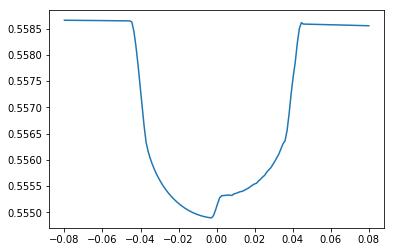

In [197]:
n_iterations = 1

residual_ptp = []

for i in range(n_iterations):
    
    # Assign random impact parameter on [0, 1]
    b = np.random.rand()
    planet.inc = np.degrees(np.arccos(b/planet.a))
    
    # Draw lambda randomly from actual lambda distribution of hot Jupiters
    planet.lam = lambdas[np.random.randint(0, len(lambdas))]
    
    # Draw spot latitude and radius from actual sunspot distributions
    lons = 360 * np.random.rand(n_spots)[:, np.newaxis] * u.deg
    lats = draw_random_sunspot_latitudes(n_spots)[:, np.newaxis]
    radii = 0.04 * np.ones(n_spots)[:, np.newaxis] # 10 * draw_random_sunspot_radii(n_spots)[:, np.newaxis]

    # Model transit light curve
    lcs, spots_occulted = star.light_curve(lons, lats, radii, inc_stellar, planet=planet, 
                                           times=times, return_spots_occulted=True, fast=True)

    if spots_occulted: 
        transit_model = TransitModel(planet, times).light_curve(planet)
        plt.plot(times, lcs)
        # Normalize out a transit model
        residuals = lcs.T[0] / transit_model

        # Normalize out trends due to stellar rotation
        residuals /= np.polyval(np.polyfit(times, residuals, 1), times)

        residual_ptp.append(residuals.ptp())

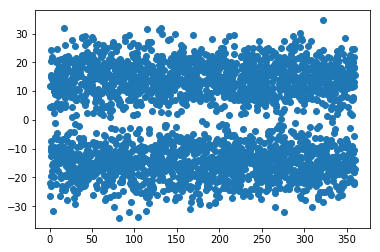

In [198]:
plt.scatter(lons, lats)

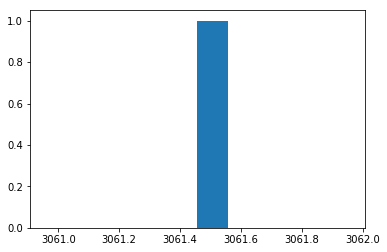

In [199]:
plt.hist(np.array(residual_ptp) * 1e6);